In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load and Preview Data

In [3]:
# Load the datasets
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [4]:
# Preview the first few rows of each dataset
print(ratings.head())
print(movies.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


# Create User-Item Matrix (Ratings Matrix)

In [6]:
# Pivot the ratings data to create a matrix with movies as rows and users as columns
final_dataset = ratings.pivot(index='movieId', columns='userId', values='rating')

In [7]:
# Replace NaN values with 0, as we assume missing ratings are unrated
final_dataset.fillna(0, inplace=True)

# Filter Data to Reduce Sparsity

In [9]:
# Filter movies rated by more than 10 users
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index, :]

In [10]:
# Filter users who have rated more than 50 movies
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')
final_dataset = final_dataset.loc[:, no_movies_voted[no_movies_voted > 50].index]

# Visualize Voting Patterns

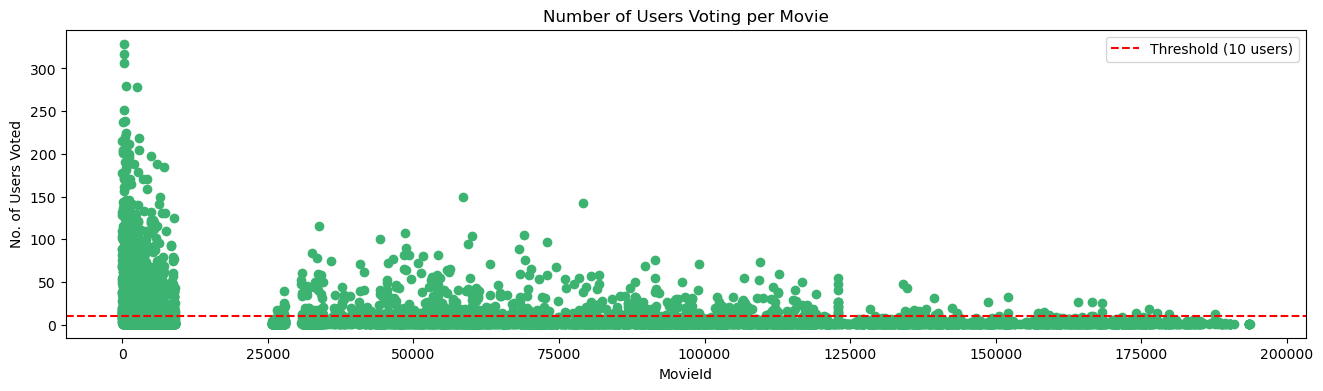

In [12]:
# Visualize the number of users voting for each movie
f, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.scatter(no_user_voted.index, no_user_voted, color='mediumseagreen')
plt.axhline(y=10, color='r', linestyle='--', label='Threshold (10 users)')
plt.title('Number of Users Voting per Movie')
plt.xlabel('MovieId')
plt.ylabel('No. of Users Voted')
plt.legend()
plt.show()

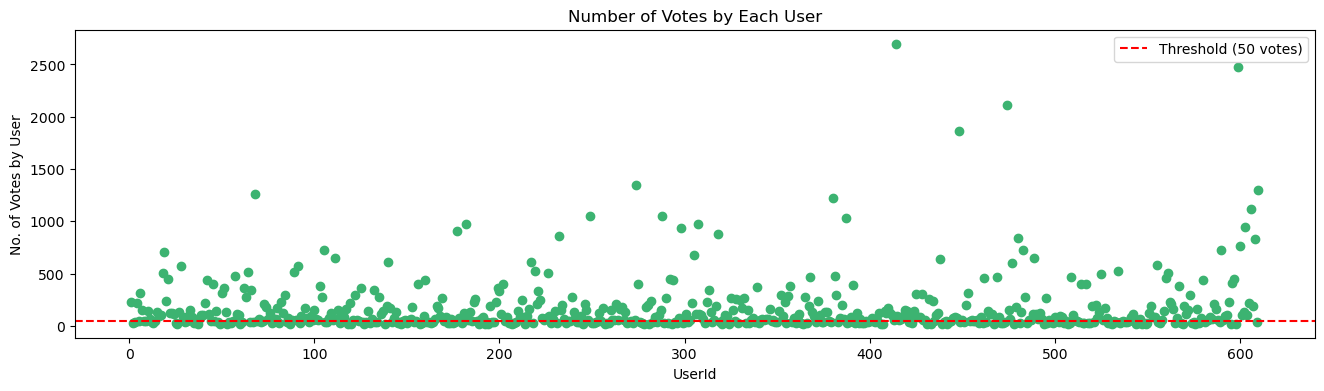

In [13]:
# Visualize the number of votes by each user
f, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.scatter(no_movies_voted.index, no_movies_voted, color='mediumseagreen')
plt.axhline(y=50, color='r', linestyle='--', label='Threshold (50 votes)')
plt.title('Number of Votes by Each User')
plt.xlabel('UserId')
plt.ylabel('No. of Votes by User')
plt.legend()
plt.show()

# Prepare Data for KNN

In [15]:
# Convert the final dataset to a sparse matrix for efficient computation
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

# Train KNN Model

In [17]:
# Initialize the KNN model with cosine similarity and brute-force algorithm
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

# Define Recommendation Function

In [19]:
def get_movie_recommendation(movie_name):
    """Get movie recommendations based on the input movie name."""
    n_movies_to_recommend = 10

    # Search for the input movie in the movies dataset
    movie_list = movies[movies['title'].str.contains(movie_name, case=False, na=False)]

    # Check if any movies match the input name
    if not movie_list.empty:
        # Get the movieId of the first matching movie
        movie_idx = movie_list.iloc[0]['movieId']

        # Ensure the movie index is in the filtered dataset
        if movie_idx in final_dataset['movieId'].values:
            # Get the row index in the final dataset
            movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]

            # Find the nearest neighbors
            distances, indices = knn.kneighbors(csr_data.getrow(movie_idx), n_neighbors=n_movies_to_recommend + 1)

            # Create a list to store recommendations
            recommend_frame = []
            for val in zip(indices.squeeze().tolist(), distances.squeeze().tolist()):
                if val[0] != movie_idx:  # Exclude the input movie itself
                    movie_id = final_dataset.iloc[val[0]]['movieId']
                    title = movies[movies['movieId'] == movie_id]['title'].values[0]
                    recommend_frame.append({'Title': title, 'Distance': val[1]})

            # Return recommendations as a DataFrame
            return pd.DataFrame(recommend_frame, index=range(1, n_movies_to_recommend + 1))
        else:
            return "The input movie is not in the filtered dataset."
    else:
        return "No movies found. Please check your input."

# Example Usage

In [21]:
# Get recommendations for a movie
recommendations = get_movie_recommendation('Iron Man')
print(recommendations)

                             Title  Distance
1             Avengers, The (2012)  0.285319
2          Dark Knight, The (2008)  0.285835
3                    WALL·E (2008)  0.298138
4                Iron Man 2 (2010)  0.307492
5                    Avatar (2009)  0.310893
6             Batman Begins (2005)  0.362759
7                 Star Trek (2009)  0.366029
8                  Watchmen (2009)  0.368558
9   Guardians of the Galaxy (2014)  0.368758
10                       Up (2009)  0.368857


In [22]:
# Test with another example
recommendations = get_movie_recommendation('Four Rooms')
print(recommendations)

                                                Title  Distance
1              Crocodile Dundee in Los Angeles (2001)  0.548971
2   Master and Commander: The Far Side of the Worl...  0.555526
3                     Witches of Eastwick, The (1987)  0.578516
4                                     WarGames (1983)  0.596966
5                          Lost in Translation (2003)  0.607221
6                Twin Peaks: Fire Walk with Me (1992)  0.612341
7                    Man Who Wasn't There, The (2001)  0.615694
8                  Big Trouble in Little China (1986)  0.618067
9                          Intolerable Cruelty (2003)  0.621591
10                                 Barton Fink (1991)  0.624177
